In [3]:
using Distributions
using Statistics
using Roots
using Plots
using DataFrames
using LaTeXStrings

In [4]:
ϕ(x, y; H = 1) = max.(y .- x, 0) .- H .* max.(x .- y, 0)
ϕ′(x, y; H = 1) = max.(x .- y, 0) .- H .* max.(y .- x, 0)
ψ(x, y; K = 1) = max.(y .- x, 0) .- K .* max.(x .- y, 0)
ψ′(x, y; K = 1) = max.(x .- y, 0) .- K .* max.(y .- x, 0)

ψ′ (generic function with 1 method)

In [5]:
function data_generation(N = 10000; H = exp(0.1), K = exp(0.5))
    N = 10000 # number of total observations
    
    # unobserved confounder for external validity
    U = rand(Normal(), N)
    
    # DGP for S₁ and G. They all depend on U.
    S₁ = 5 * (rand(N) .< (0.5 .- 0.3*(U.>0))) .+ 5 
    G = rand(N) .> (1 ./ (1 .+ exp.(-log(H).* (U.>0)))); 
    
    # unobserved confounder for latent unconfoundedness
    V = rand(Normal(), N);
    
    # DGP for Y₁ and D. They all depend on V.
    Y₁ = S₁ + V + randn(N);
    D = similar(G);
    
    # randomization in the experimental sample
    D[G .== 1] = rand((0,1), sum(G .== 1))
    
    # K-latent-confoundedness
    D[G .== 0] = rand(sum(G .== 0)) .> 
    (1 ./ (1 .+ exp.(-log(K).* (V[G .== 0].>0) .- 0.1 .*S₁[G .== 0])))
    
    df = DataFrame(G = G, S1 = S₁, D=D, Y1 = Y₁, S = D.*S₁, Y = D.*Y₁)
end

data_generation (generic function with 2 methods)

In [6]:
function lower(m; K=exp(0.5), H=exp(0.1), df = df)
    ϕ(x, y) = max.(y .- x, 0) .- H .* max.(x .- y, 0)
    ϕ′(x, y) = max.(x .- y, 0) .- H .* max.(y .- x, 0)
    ψ(x, y) = max.(y .- x, 0) .- K .* max.(x .- y, 0)
    ψ′(x, y) = max.(x .- y, 0) .- K .* max.(y .- x, 0)
    
    f(s) = m -> mean((df.D .== 1) .* (df.G .== 0) .* (df.S .≈ s) .* ψ(m, df.Y))
    g(s) = m -> mean((df.D .== 1) .* (df.G .== 0) .* (df.S .≈ s) .* ψ′(m, df.Y))
    
    θ1minushat_s1 = find_zero(f(5), 2.0)
    θ1minushat_s2 = find_zero(f(10), 2.0)
    
    return mean((df.D.==1) .* (df.G .== 1) .*
    (df.S .== 5) .* ϕ(m, θ1minushat_s1)) + mean((df.D.==1) .* (df.G .== 1) .*
    (df.S .== 10) .* ϕ(m, θ1minushat_s2)) 
end

lower (generic function with 1 method)

In [7]:
function upper(m; K=exp(0.5), H=exp(0.1), df = df)
    ϕ(x, y) = max.(y .- x, 0) .- H .* max.(x .- y, 0)
    ϕ′(x, y) = max.(x .- y, 0) .- H .* max.(y .- x, 0)
    ψ(x, y) = max.(y .- x, 0) .- K .* max.(x .- y, 0)
    ψ′(x, y) = max.(x .- y, 0) .- K .* max.(y .- x, 0)
    
    f(s) = m -> mean((df.D .== 1) .* (df.G .== 0) .* (df.S .≈ s) .* ψ(m, df.Y))
    g(s) = m -> mean((df.D .== 1) .* (df.G .== 0) .* (df.S .≈ s) .* ψ′(m, df.Y))
    
    θ1plushat_s1 = find_zero(g(5), 2.0)
    θ1plushat_s2 = find_zero(g(10), 2.0)
    
    return mean((df.D.==1) .* (df.G .== 1) .*
    (df.S .== 5) .* ϕ′(m, θ1plushat_s1)) + mean((df.D.==1) .* (df.G .== 1) .*
    (df.S .== 10) .* ϕ′(m, θ1plushat_s2)) 
end

upper (generic function with 1 method)

In [8]:
function compute_lower_Y1(df; K=1, H=1)
    
    f(s; df = df, K = K) = m -> mean((df.D .== 1) .* (df.G .== 0) .* (df.S .≈ s) .* ψ(m, df.Y; K = K))
    
    θ1minushat_s1 = find_zero(f(5; df = df, K=K), 2.0)
    θ1minushat_s2 = find_zero(f(10; df = df, K=K), 2.0)
    
    μ1minus = find_zero(m -> lower(m; df=df, K=K, H=H), 2.0) / mean(df[df.G .== 0, :D].== 0) - 
    (θ1minushat_s1 * mean(df[ (df.D.==1) .* (df.G .== 0), :S] .== 5) + 
    θ1minushat_s2 * mean(df[ (df.D.==1) .* (df.G .== 0), :S] .== 10) ) * 
    mean(df[df.G .== 0, :D].== 1) /
    mean(df[df.G .== 0, :D].== 0)
    
    lower_Y1 = mean(df[ (df.G .== 0) .* (df.D .== 1 ), :Y]) * 
        mean(df[df.G .== 0, :D].== 1) +  
        μ1minus* 
        mean(df[df.G .== 0, :D].== 0)
end

compute_lower_Y1 (generic function with 1 method)

In [9]:
function compute_upper_Y1(df; K = exp(0.5), H = exp(0.1))
    
    g(s; df = df, K = K) = m -> mean((df.D .== 1) .* (df.G .== 0) .* (df.S .≈ s) .* ψ′(m, df.Y; K = K))
    
    θ1plushat_s1 = find_zero(g(5; df = df, K = K), 2.0)
    θ1plushat_s2 = find_zero(g(10; df = df, K = K), 2.0)
    
    μ1plus = find_zero(m -> upper(m; df=df, K=K, H=H), 2.0) / mean(df[df.G .== 0, :D].== 0) - (θ1plushat_s1 * mean(df[ (df.D.==1) .* (df.G .== 0), :S] .== 5) + 
    θ1plushat_s2 * mean(df[ (df.D.==1) .* (df.G .== 0), :S] .== 10) ) * 
    mean(df[df.G .== 0, :D].== 1) /
    mean(df[df.G .== 0, :D].== 0)
    
    upper_Y1 = mean(df[ (df.G .== 0) .* (df.D .== 1 ), :Y]) * 
        mean(df[df.G .== 0, :D].== 1) +  
        μ1plus* 
        mean(df[df.G .== 0, :D].== 0)
end

compute_upper_Y1 (generic function with 1 method)

In [10]:
function lower2(m; K=exp(0.5), H=exp(0.1), df = df)
    ϕ(x, y) = max.(y .- x, 0) .- H .* max.(x .- y, 0)
    ϕ′(x, y) = max.(x .- y, 0) .- H .* max.(y .- x, 0)
    ψ(x, y) = max.(y .- x, 0) .- K .* max.(x .- y, 0)
    ψ′(x, y) = max.(x .- y, 0) .- K .* max.(y .- x, 0)
    
    f(s) = m -> mean((df.D .== 0) .* (df.G .== 0) .* (df.S .≈ s) .* ψ(m, df.Y))
    g(s) = m -> mean((df.D .== 0) .* (df.G .== 0) .* (df.S .≈ s) .* ψ′(m, df.Y))
    
    θ0minushat_s1 = find_zero(f(5), 0.0)
    θ0minushat_s2 = find_zero(f(10), 0.0)
    
    return mean((df.D.==0) .* (df.G .== 1) .*
    (df.S .== 5) .* ϕ(m, θ0minushat_s1)) + mean((df.D.==0) .* (df.G .== 1) .*
    (df.S .== 10) .* ϕ(m, θ0minushat_s2)) 
end

lower2 (generic function with 1 method)

In [11]:
function upper2(m; K=exp(0.5), H=exp(0.1), df = df)
    ϕ(x, y) = max.(y .- x, 0) .- H .* max.(x .- y, 0)
    ϕ′(x, y) = max.(x .- y, 0) .- H .* max.(y .- x, 0)
    ψ(x, y) = max.(y .- x, 0) .- K .* max.(x .- y, 0)
    ψ′(x, y) = max.(x .- y, 0) .- K .* max.(y .- x, 0)
    
    f(s) = m -> mean((df.D .== 0) .* (df.G .== 0) .* (df.S .≈ s) .* ψ(m, df.Y))
    g(s) = m -> mean((df.D .== 0) .* (df.G .== 0) .* (df.S .≈ s) .* ψ′(m, df.Y))
    
    θ0plushat_s1 = find_zero(g(5), 0.0)
    θ0plushat_s2 = find_zero(g(10), 0.0)
    
    return mean((df.D.==0) .* (df.G .== 1) .*
    (df.S .== 5) .* ϕ′(m, θ0plushat_s1)) + mean((df.D.==0) .* (df.G .== 1) .*
    (df.S .== 10) .* ϕ′(m, θ0plushat_s2)) 
end

upper2 (generic function with 1 method)

In [12]:
function compute_lower_Y0(df; K=1, H=1)
    
    f(s; df = df, K = K) = m -> mean((df.D .== 0) .* (df.G .== 0) .* (df.S .≈ s) .* ψ(m, df.Y; K = K))
    
    θ0minushat_s1 = find_zero(f(5; df = df, K=K), 0.0)
    θ0minushat_s2 = find_zero(f(10; df = df, K=K), 0.0)
    
    μ0minus = find_zero(m -> lower2(m; df=df, K=K, H=H), 0.0) / mean(df[df.G .== 0, :D].== 1) - 
    (θ0minushat_s1 * mean(df[ (df.D.==0) .* (df.G .== 0), :S] .== 5) + 
    θ0minushat_s2 * mean(df[ (df.D.==0) .* (df.G .== 0), :S] .== 10) ) * 
    mean(df[df.G .== 0, :D].== 0) /
    mean(df[df.G .== 0, :D].== 1)
    
    lower_Y0 = mean(df[ (df.G .== 0) .* (df.D .== 0 ), :Y]) * 
        mean(df[df.G .== 0, :D].== 0) +  
        μ0minus* 
        mean(df[df.G .== 0, :D].== 1)
end

compute_lower_Y0 (generic function with 1 method)

In [13]:
function compute_upper_Y0(df; K = exp(0.5), H = exp(0.1))
    
    g(s; df = df, K = K) = m -> mean((df.D .== 0) .* (df.G .== 0) .* (df.S .≈ s) .* ψ′(m, df.Y; K = K))
    
    θ0plushat_s1 = find_zero(g(5; df = df, K = K), 0.0)
    θ0plushat_s2 = find_zero(g(10; df = df, K = K), 0.0)
    
    μ0plus = find_zero(m -> upper2(m; df=df, K=K, H=H), 0.0) / mean(df[df.G .== 0, :D].== 1) - 
    (θ0plushat_s1 * mean(df[ (df.D.==0) .* (df.G .== 0), :S] .== 5) + 
    θ0plushat_s2 * mean(df[ (df.D.==0) .* (df.G .== 0), :S] .== 10) ) * 
    mean(df[df.G .== 0, :D].== 0) /
    mean(df[df.G .== 0, :D].== 1)
    
    upper_Y0 = mean(df[ (df.G .== 0) .* (df.D .== 0 ), :Y]) * 
        mean(df[df.G .== 0, :D].== 0) +  
        μ0plus* 
        mean(df[df.G .== 0, :D].== 1)
end

compute_upper_Y0 (generic function with 1 method)

In [59]:
function data_generation2(N = 10000; H = exp(0.1), K = exp(0.5))
    τ = 1

    # unobserved confounder for external validity
    U = rand(Normal(), N)

    # DGP for S₁ and G. They all depend on U.
    S₀ = 5 * (rand(N) .< (0.5 .+ 0.15 * (U .> 0))) .+ 5
    S₁ = 5 * (rand(N) .< (0.5 .+ 0.3 * (U .> 0))) .+ 5
    G = rand(N) .< (1 ./ (1 .+ exp.(-log(H) .* (U .> 0))))

    # unobserved confounder for latent unconfoundedness
    V = rand(Normal(), N)

    # DGP for Y₁ and D. They all depend on V.
    Y₀ = S₀ + 5 * V + randn(N)
    Y₁ = Y₀ .+ τ
    D = similar(G)

    # randomization in the experimental sample
    D[G.==1] = rand((0, 1), sum(G .== 1))

    # K-latent-confoundedness
    D[G.==0] = rand(sum(G .== 0)) .<
               (1 ./ (1 .+ exp.(-log(K) .* (V[G.==0] .> 0) - 0.5 .* (U[G .== 0] .> 0) )))

    df = DataFrame(G = G, S1 = S₁, S0 = S₀, D = D, Y1 = Y₁, Y0 = Y₀,
        S = D .* S₁ .+ (1 .- D) .* S₀, Y = D .* Y₁ .+ (1 .- D) .* Y₀)
end

data_generation2 (generic function with 2 methods)

In [60]:
df2 = data_generation2(1000; H = 1, K = 1)

,G,S1,S0,D,Y1,Y0,S,Y
,Bool,Int64,Int64,Bool,Float64,Float64,Int64,Float64
1,0,5,5,1,5.80415,4.80415,5,5.80415
2,0,10,10,1,7.34039,6.34039,10,7.34039
3,0,10,10,1,16.0329,15.0329,10,16.0329
4,1,5,10,1,13.022,12.022,5,13.022
5,1,10,5,1,2.75242,1.75242,10,2.75242
6,0,5,10,1,16.7365,15.7365,5,16.7365
7,0,5,10,1,12.5047,11.5047,5,12.5047
8,1,5,5,0,5.56652,4.56652,5,4.56652
9,1,5,10,1,21.9314,20.9314,5,21.9314


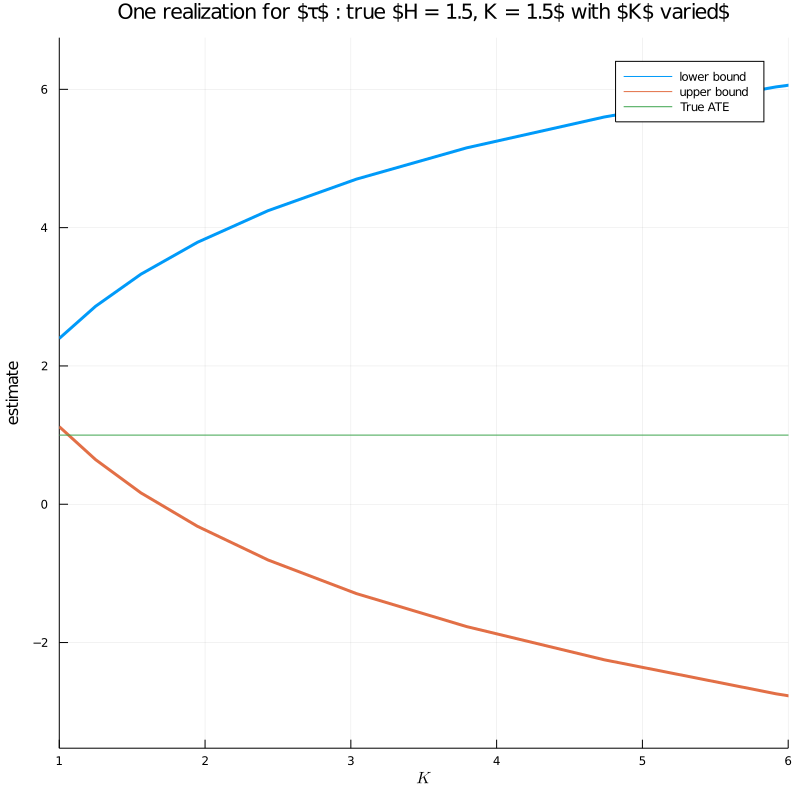

In [61]:
df2 = data_generation2(1000; K = 1.5, H = 1.5)
Ks = exp.(LinRange(0.0, 2, 10))
plot(Ks, [compute_upper_Y1(df2; K = K, H = 1.5) - compute_lower_Y0(df2; K = K, H = 1.5) for K in Ks], xlim = (1, 6), label = "lower bound", lw = 3)
plot!(Ks, [compute_lower_Y1(df2; K = K, H = 1.5) - compute_upper_Y0(df2; K = K, H = 1.5) for K in Ks], label = "upper bound", lw = 3)
plot!(leg = :best)
hline!([1], label = "True ATE")
plot!(title = L"One realization for $\tau$ : true $H = 1.5, K = 1.5$ with $K$ varied$")
plot!(xlabel = L"$K$", ylabel = "estimate")
plot!(size = (800, 800))
# savefig("fig1.png")

In [19]:
using Random
Random.seed!(3)

MersenneTwister(3)

In [20]:
sp = 1.2
upper_bound_τ = []
oracle_τ = []
lower_bound_τ = []

for _ in 1:2000
    df2 = data_generation2(500; K = sp, H = sp)
    push!(upper_bound_τ, compute_upper_Y1(df2; K = sp, H = sp) - compute_lower_Y0(df2; K = sp, H = sp))
    push!(lower_bound_τ, compute_lower_Y1(df2; K = sp, H = sp) - compute_upper_Y0(df2; K = sp, H = sp))
    push!(oracle_τ, mean(df2[df2.G.==0, :Y1] - df2[df2.G.==0, :Y0]))
end

histogram(upper_bound_τ, bins = 50, alpha = 0.1, label = "upper bound")
histogram!(lower_bound_τ, bins = 50, alpha = 0.1, label = "lower bound")
vline!([1], label = L"true $\tau$")
plot!(xlabel = "estimate", ylabel = "freq", title = "Histogram for estimates", size = (800, 800))
savefig("fig2.png")

sigma_l = std(lower_bound_τ)
sigma_h = std(upper_bound_τ)

println("n = 500")
println(L"\tau^-", mean(lower_bound_τ))
println(L"Std. Dev. of $\tau$", sigma_l)
println(L"\tau^+", mean(upper_bound_τ))
println(L"Std. Dev. of $\tau$", sigma_h)
println("coverage", mean(upper_bound_τ .+ 1.96 * sigma_h .> 1 .> lower_bound_τ .- 1.96 * sigma_l))

n = 500
$\tau^-$0.8027683792011951
Std. Dev. of $\tau$0.7120100023236416
$\tau^-$2.0802237104989367
Std. Dev. of $\tau$0.7159826552541644
coverage0.9895


In [26]:
sp = 1.2
upper_bound_τ = []
oracle_τ = []
lower_bound_τ = []

for _ in 1:2000
    df2 = data_generation2(1000; K = sp, H = sp)
    push!(upper_bound_τ, compute_upper_Y1(df2; K = sp, H = sp) - compute_lower_Y0(df2; K = sp, H = sp))
    push!(lower_bound_τ, compute_lower_Y1(df2; K = sp, H = sp) - compute_upper_Y0(df2; K = sp, H = sp))
    push!(oracle_τ, mean(df2[df2.G.==0, :Y1] - df2[df2.G.==0, :Y0]))
end

histogram(upper_bound_τ, bins = 50, alpha = 0.1, label = "upper bound")
histogram!(lower_bound_τ, bins = 50, alpha = 0.1, label = "lower bound")
vline!([1], label = L"true $\tau$")
plot!(xlabel = "estimate", ylabel = "freq", title = "Histogram for estimates", size = (800, 800))
savefig("fig2.png")

sigma_l = std(lower_bound_τ)
sigma_h = std(upper_bound_τ)

println("n = 1000")
println(L"\tau^-", mean(lower_bound_τ))
println(L"Std. Dev. of $\tau$", sigma_l)
println(L"\tau^-", mean(upper_bound_τ))
println(L"Std. Dev. of $\tau$", sigma_h)
println("coverage", mean(upper_bound_τ .+ 1.96 * sigma_h .> 1 .> lower_bound_τ .- 1.96 * sigma_l))

n = 1000
$\tau^-$0.7975874369603996
Std. Dev. of $\tau$0.505659288339231
$\tau^-$2.0622392296907393
Std. Dev. of $\tau$0.5088518126043838
coverage0.988


In [22]:
sp = 1.2
upper_bound_τ = []
oracle_τ = []
lower_bound_τ = []

for _ in 1:2000
    df2 = data_generation2(2000; K = sp, H = sp)
    push!(upper_bound_τ, compute_upper_Y1(df2; K = sp, H = sp) - compute_lower_Y0(df2; K = sp, H = sp))
    push!(lower_bound_τ, compute_lower_Y1(df2; K = sp, H = sp) - compute_upper_Y0(df2; K = sp, H = sp))
    push!(oracle_τ, mean(df2[df2.G.==0, :Y1] - df2[df2.G.==0, :Y0]))
end

histogram(upper_bound_τ, bins = 50, alpha = 0.1, label = "upper bound")
histogram!(lower_bound_τ, bins = 50, alpha = 0.1, label = "lower bound")
vline!([1], label = L"true $\tau$")
plot!(xlabel = "estimate", ylabel = "freq", title = "Histogram for estimates", size = (800, 800))
savefig("fig2.png")

sigma_l = std(lower_bound_τ)
sigma_h = std(upper_bound_τ)

println("n = 2000")
println(L"\tau^-", mean(lower_bound_τ))
println(L"Std. Dev. of $\tau$", sigma_l)
println(L"\tau^-", mean(upper_bound_τ))
println(L"Std. Dev. of $\tau$", sigma_h)
println("coverage", mean(upper_bound_τ .+ 1.96 * sigma_h .> 1 .> lower_bound_τ .- 1.96 * sigma_l))

n = 2000
$\tau^-$0.8023699518457239
Std. Dev. of $\tau$0.3638810301802214
$\tau^-$2.0551814598227964
Std. Dev. of $\tau$0.3653975804539353
coverage0.995


In [23]:
sp = 1
upper_bound_τ = []
oracle_τ = []
lower_bound_τ = []

for _ in 1:2000
    df2 = data_generation2(500; K = sp, H = sp)
    push!(upper_bound_τ, compute_upper_Y1(df2; K = sp, H = sp) - compute_lower_Y0(df2; K = sp, H = sp))
    push!(lower_bound_τ, compute_lower_Y1(df2; K = sp, H = sp) - compute_upper_Y0(df2; K = sp, H = sp))
    push!(oracle_τ, mean(df2[df2.G.==0, :Y1] - df2[df2.G.==0, :Y0]))
end

histogram(upper_bound_τ, bins = 50, alpha = 0.1, label = "upper bound")
histogram!(lower_bound_τ, bins = 50, alpha = 0.1, label = "lower bound")
vline!([1], label = L"true $\tau$")
plot!(xlabel = "estimate", ylabel = "freq", title = "Histogram for estimates", size = (800, 800))
savefig("fig2.png")

sigma_l = std(lower_bound_τ)
sigma_h = std(upper_bound_τ)

println("n = 500")
println(L"\tau^-", mean(lower_bound_τ))
println(L"Std. Dev. of $\tau$", sigma_l)
println(L"\tau^-", mean(upper_bound_τ))
println(L"Std. Dev. of $\tau$", sigma_h)
println("coverage", mean(upper_bound_τ .+ 1.96 * sigma_h .> 1 .> lower_bound_τ .- 1.96 * sigma_l))

n = 2000
$\tau^-$1.0380950118065349
Std. Dev. of $\tau$0.7318399092243633
$\tau^-$1.0380950118065349
Std. Dev. of $\tau$0.7318399092243633
coverage0.9485


In [24]:
sp = 1
upper_bound_τ = []
oracle_τ = []
lower_bound_τ = []

for _ in 1:2000
    df2 = data_generation2(1000; K = sp, H = sp)
    push!(upper_bound_τ, compute_upper_Y1(df2; K = sp, H = sp) - compute_lower_Y0(df2; K = sp, H = sp))
    push!(lower_bound_τ, compute_lower_Y1(df2; K = sp, H = sp) - compute_upper_Y0(df2; K = sp, H = sp))
    push!(oracle_τ, mean(df2[df2.G.==0, :Y1] - df2[df2.G.==0, :Y0]))
end

histogram(upper_bound_τ, bins = 50, alpha = 0.1, label = "upper bound")
histogram!(lower_bound_τ, bins = 50, alpha = 0.1, label = "lower bound")
vline!([1], label = L"true $\tau$")
plot!(xlabel = "estimate", ylabel = "freq", title = "Histogram for estimates", size = (800, 800))
savefig("fig2.png")

sigma_l = std(lower_bound_τ)
sigma_h = std(upper_bound_τ)

println("n = 1000")
println(L"\tau^-", mean(lower_bound_τ))
println(L"Std. Dev. of $\tau$", sigma_l)
println(L"\tau^-", mean(upper_bound_τ))
println(L"Std. Dev. of $\tau$", sigma_h)
println("coverage", mean(upper_bound_τ .+ 1.96 * sigma_h .> 1 .> lower_bound_τ .- 1.96 * sigma_l))

n = 1000
$\tau^-$1.0390572634113282
Std. Dev. of $\tau$0.49570496103718037
$\tau^-$1.0390572634113282
Std. Dev. of $\tau$0.49570496103718037
coverage0.9455


In [25]:
sp = 1
upper_bound_τ = []
oracle_τ = []
lower_bound_τ = []

for _ in 1:2000
    df2 = data_generation2(2000; K = sp, H = sp)
    push!(upper_bound_τ, compute_upper_Y1(df2; K = sp, H = sp) - compute_lower_Y0(df2; K = sp, H = sp))
    push!(lower_bound_τ, compute_lower_Y1(df2; K = sp, H = sp) - compute_upper_Y0(df2; K = sp, H = sp))
    push!(oracle_τ, mean(df2[df2.G.==0, :Y1] - df2[df2.G.==0, :Y0]))
end

histogram(upper_bound_τ, bins = 50, alpha = 0.1, label = "upper bound")
histogram!(lower_bound_τ, bins = 50, alpha = 0.1, label = "lower bound")
vline!([1], label = L"true $\tau$")
plot!(xlabel = "estimate", ylabel = "freq", title = "Histogram for estimates", size = (800, 800))
savefig("fig2.png")

sigma_l = std(lower_bound_τ)
sigma_h = std(upper_bound_τ)

println("n = 2000")
println(L"\tau^-", mean(lower_bound_τ))
println(L"Std. Dev. of $\tau$", sigma_l)
println(L"\tau^-", mean(upper_bound_τ))
println(L"Std. Dev. of $\tau$", sigma_h)
println("coverage", mean(upper_bound_τ .+ 1.96 * sigma_h .> 1 .> lower_bound_τ .- 1.96 * sigma_l))

n = 2000
$\tau^-$1.0290152371886407
Std. Dev. of $\tau$0.3569225372080426
$\tau^-$1.0290152371886407
Std. Dev. of $\tau$0.3569225372080426
coverage0.947


In [26]:
upper_bound_Y0 = []
oracle_Y0 = []
lower_bound_Y0 = []

for i in 1:500
    df2 = data_generation2(800; K = 1.5, H = 1.5)
    push!(upper_bound_Y0, compute_upper_Y0(df2; K = 1.5, H = 1.5))
    push!(lower_bound_Y0, compute_lower_Y0(df2; K = 1.5, H = 1.5))
    push!(oracle_Y0, mean(df2[df2.G.==0, :Y0]))
end

histogram(upper_bound_Y0, bins = 50, alpha = 0.1, label = "upper bound")
histogram!(lower_bound_Y0, bins = 50, alpha = 0.1, label = "lower bound")
vline!([mean(oracle_Y0)], label = L"true $Y_{0}$")

LoadError: InterruptException:

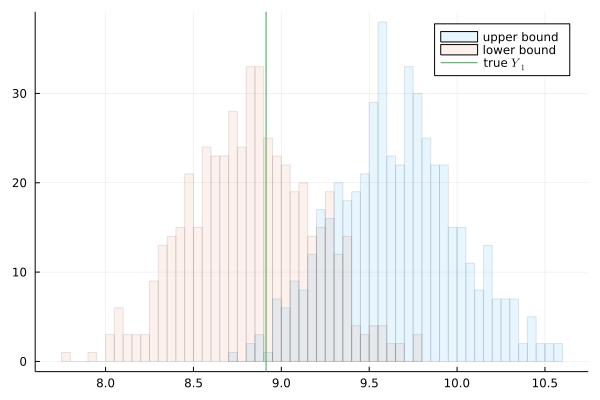

In [20]:
upper_bound_Y1 = []
oracle_Y1 = []
lower_bound_Y1 = []

for i in 1:500
    df2 = data_generation2(800; K = 1.5, H = 1.5)
    push!(upper_bound_Y1, compute_upper_Y1(df2; K = 1.5, H = 1.5))
    push!(lower_bound_Y1, compute_lower_Y1(df2; K = 1.5, H = 1.5))
    push!(oracle_Y1, mean(df2[df2.G.==0, :Y1]))
end

histogram(upper_bound_Y1, bins = 50, alpha = 0.1, label = "upper bound")
histogram!(lower_bound_Y1, bins = 50, alpha = 0.1, label = "lower bound")
vline!([mean(oracle_Y1)], label = L"true $Y_{1}$")